In [1]:
from diffusers import DiffusionPipeline
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt

from diffusers import PNDMScheduler

# 创建 PNDMScheduler 实例
scheduler = PNDMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    prediction_type="epsilon",
    set_alpha_to_one=False,
    skip_prk_steps=True,
    steps_offset=1,
    trained_betas=None
)

# 输出scheduler的配置，确保正确设置
print(scheduler)

/HOME/scz0ruj/.conda/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.12.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



In [2]:
%run 22.vae.ipynb
%run 33.Unet.ipynb
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vae.to(device)
unet.to(device)


vae.eval()
unet.eval()

/data/run01/scz0ruj/model/lcynew_unet_model_parameters1.pth


UNet(
  (in_vae): Conv2d(4, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_time): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
  )
  (down_block0): DownBlock(
    (tf0): Transformer(
      (norm_in): GroupNorm(32, 160, eps=1e-06, affine=True)
      (cnn_in): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
      (norm_atten0): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (atten1): CrossAttention(
        (q): Linear(in_features=160, out_features=160, bias=False)
        (k): Linear(in_features=160, out_features=160, bias=False)
        (v): Linear(in_features=160, out_features=160, bias=False)
        (out): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm_atten1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (atten2): CrossAttention(
        (q): Linear(in_features=160, out_features=160, bias=False)
        (k): Linear(in_features=768, out_features=160, bias=False)
   

In [3]:
@torch.no_grad()
def generate(text):
    
    #词编码
    text = torch.tensor(text, dtype=torch.float32)  # 确保数据类型一致
    
    # 定义条件均值和标准差
    condition_mean = torch.tensor([3.84952491e+02 ,2.43981134e+02, 1.12512536e+00 ,1.84848683e-01 ]).to(device)
    condition_std = torch.tensor([1.19021432e+02, 1.23790469e+02,1.13191379e+00 ,2.54632684e-02]).to(device)
    
    text = text.to(device)
    text=(text - condition_mean) / condition_std
    expanded_input_ids = text.unsqueeze(-1).repeat(1, 1, 768)
    print(text)
    




    #[1+1, 77, 768] -> [2, 77, 768]
    out_encoder = expanded_input_ids

    #vae的压缩图,从随机噪声开始
    out_vae = torch.randn(1, 4, 32, 32, device=device)

    #生成50个时间步,一般是从980-0
    scheduler.set_timesteps(50, device=device)
    for time in scheduler.timesteps:

        #往图中加噪音
        #[1+1, 4, 64, 64] -> [2, 4, 64, 64]
        noise = out_vae
        noise = scheduler.scale_model_input(noise, time)

        #计算噪音
        #[2, 4, 64, 64],[2, 77, 768],scala -> [2, 4, 64, 64]
        pred_noise = unet(out_vae=noise, out_encoder=out_encoder, time=time)


        #重新添加噪音,以进行下一步计算
        #[1, 4, 64, 64]
        out_vae = scheduler.step(pred_noise, time, out_vae).prev_sample

    #从压缩图恢复成图片
    out_vae = 1 / 0.18215 * out_vae
    #[1, 4, 64, 64] -> [1, 3, 512, 512]
    image = vae.decoder(out_vae)

    #转换成图片数据
    image = image.cpu()
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    image = image.permute(0, 2, 3, 1)
    return image.numpy()[0]

tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')


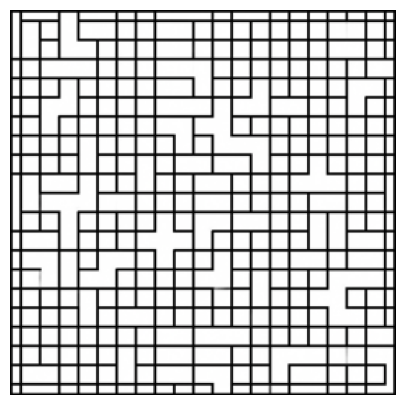

tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 1 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_1.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 2 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_2.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 3 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_3.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 4 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_4.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 5 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_5.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 6 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_6.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 7 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_7.png
tensor([1.8068, 0.45

第 59 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_59.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 60 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_60.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 61 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_61.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 62 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_62.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 63 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_63.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 64 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_64.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 65 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_65.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 66 张

第 117 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_117.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 118 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_118.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 119 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_119.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 120 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_120.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 121 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_121.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 122 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_122.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 123 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_123.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 174 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_174.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 175 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_175.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 176 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_176.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 177 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_177.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 178 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_178.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 179 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_179.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 180 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_180.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 231 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_231.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 232 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_232.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 233 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_233.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 234 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_234.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 235 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_235.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 236 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_236.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 237 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_237.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 288 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_288.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 289 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_289.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 290 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_290.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 291 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_291.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 292 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_292.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 293 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_293.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 294 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_294.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 345 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_345.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 346 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_346.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 347 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_347.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 348 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_348.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 349 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_349.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 350 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_350.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 351 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_351.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 402 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_402.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 403 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_403.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 404 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_404.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 405 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_405.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 406 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_406.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 407 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_407.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 408 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_408.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 459 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_459.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 460 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_460.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 461 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_461.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 462 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_462.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 463 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_463.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 464 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_464.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 465 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_465.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 516 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_516.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 517 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_517.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 518 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_518.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 519 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_519.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 520 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_520.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 521 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_521.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 522 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_522.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 573 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_573.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 574 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_574.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 575 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_575.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 576 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_576.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 577 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_577.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 578 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_578.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 579 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_579.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 630 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_630.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 631 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_631.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 632 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_632.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 633 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_633.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 634 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_634.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 635 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_635.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 636 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_636.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 687 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_687.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 688 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_688.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 689 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_689.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 690 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_690.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 691 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_691.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 692 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_692.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 693 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_693.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 744 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_744.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 745 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_745.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 746 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_746.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 747 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_747.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 748 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_748.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 749 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_749.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 750 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_750.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 801 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_801.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 802 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_802.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 803 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_803.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 804 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_804.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 805 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_805.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 806 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_806.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 807 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_807.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 858 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_858.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 859 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_859.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 860 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_860.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 861 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_861.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 862 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_862.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 863 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_863.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 864 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_864.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 915 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_915.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 916 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_916.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 917 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_917.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 918 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_918.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 919 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_919.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 920 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_920.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 921 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_921.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

第 972 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_972.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 973 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_973.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 974 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_974.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 975 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_975.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 976 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_976.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 977 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_977.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='cuda:0')
第 978 张图片已成功保存至: /data/run01/scz0ruj/newpic1/600_300_1.67_0.2/generated_image_978.png
tensor([1.8068, 0.4525, 0.4814, 0.5950], device='c

In [4]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline


texts =[600,300,1.67,0.2]

images =generate(texts)
plt.figure(figsize=(10, 5))
plt.imshow(images)
plt.axis('off')
plt.show()




# Create a folder with the name derived from texts
folder_name = '_'.join(map(str, texts))  # Convert the list to a string separated by underscores
folder_path = os.path.join("/data/run01/scz0ruj/newpic1/", folder_name)  # Change "/path/to/save/" to your desired directory

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# 生成并保存多张图片
num_images = 1000
for i in range(num_images):
    # 生成图片
    image = generate(texts)
    
    # 反归一化（乘以255）
    image = (image * 255).astype(np.uint8)
    
    # 转换为PIL Image对象
    image_pil = Image.fromarray(image)
    
    # 指定保存的文件路径
    file_name = f"generated_image_{i+1}.png"
    file_path = os.path.join(folder_path, file_name)
    
    # 保存图片
    image_pil.save(file_path)
    
    print("第", i+1, "张图片已成功保存至:", file_path)


/tmp/ipykernel_27055/1907997001.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/utils/tensor_new.cpp:201.)
  image_tensor = torch.tensor([image_data], dtype=torch.float32).to(device)  # 加入batch维度


处理完成，所有生成的图片已保存到指定的输出文件夹。


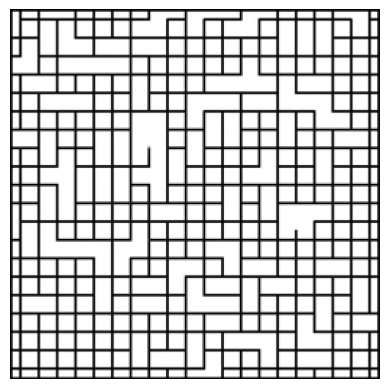

In [5]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def get_data_custom(image_path, image_size=(256,256)):
    """
    Load and preprocess image data from a specified path.
    """
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized, dtype=np.float32)
        img_normalized = (img_array - 127.5) / 127.5
        img_transposed = img_normalized.transpose(2, 0, 1)
    return img_transposed

def plt_save(tensor, file_name):
    """
    Function to save an image from a PyTorch tensor.
    """
    tensor = tensor.squeeze()  # Remove batch dimension if present
    tensor = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC
    tensor = (tensor + 1) / 2  # Normalize to [0, 1] for proper visualization
    tensor = tensor.clamp(0, 1)  # Clamp to ensure values are between 0 and 1
    numpy_image = tensor.cpu().numpy()
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

# 读取路径和保存路径
folder_name = '_'.join(map(str, texts))  # Convert the list to a string separated by underscores
folder_path = os.path.join("/data/run01/scz0ruj/newpic1/", folder_name)  # Change "/path/to/save/" to your desired directory
input_folder = folder_path

folder_name1 = 'new'+'_'.join(map(str, texts))  # Convert the list to a string separated by underscores
folder_path1 = os.path.join("/data/run01/scz0ruj/newpic1/", folder_name1)  # Change "/path/to/save/" to your desired directory
output_folder = folder_path1

# 检查输出文件夹是否存在，如果不存在，创建它
os.makedirs(output_folder, exist_ok=True)

# 处理每张图片
for i in range(1, 1001):
    file_name = f"generated_image_{i}.png"
    input_path = os.path.join(input_folder, file_name)
    output_path = os.path.join(output_folder, file_name)

    # 加载和预处理图片
    image_data = get_data_custom(input_path)
    image_tensor = torch.tensor([image_data], dtype=torch.float32).to(device)  # 加入batch维度

    # 使用模型
    with torch.no_grad():
        pred, mu, log_var = vae(image_tensor)  # 假设model已经定义好

    # 保存输出图片
    plt_save(pred[0], output_path)

print("处理完成，所有生成的图片已保存到指定的输出文件夹。")